In [ ]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import warnings 
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/칼로리 데이터셋.zip'

unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/칼로리 데이터셋.zip, /content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/칼로리 데이터셋.zip.zip or /content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/칼로리 데이터셋.zip.ZIP.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/open 2/train.csv',index_col="ID")
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/open 2/test.csv',index_col="ID")
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/미니 프로젝트/미니 프로젝트5/open 2/sample_submission.csv',index_col="ID")

In [ ]:
train['Height(cm)'] = train['Height(Feet)'] * 30.48 + train['Height(Remainder_Inches)']*2.54
test['Height(cm)'] = test['Height(Feet)'] * 30.48 + test['Height(Remainder_Inches)']*2.54

In [ ]:
# 기존 ft, inch column은 삭제 
train = train.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])
test = test.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])

In [ ]:
# 몸무게를 kg   변경
train['Weight(kg)'] = train['Weight(lb)'] * 0.45359237
test['Weight(kg)'] = test['Weight(lb)'] * 0.45359237

In [ ]:
# 이전 데이터 삭제 
train = train.drop(columns=['Weight(lb)'])
test = test.drop(columns=['Weight(lb)'])

In [ ]:
train['BMI'] = train['Weight(kg)'] / ((train['Height(cm)'] / 100) ** 2)
test['BMI'] = test['Weight(kg)'] / ((test['Height(cm)'] / 100) ** 2)

In [ ]:
train=pd.get_dummies(train)
test=pd.get_dummies(test)

<Axes: >

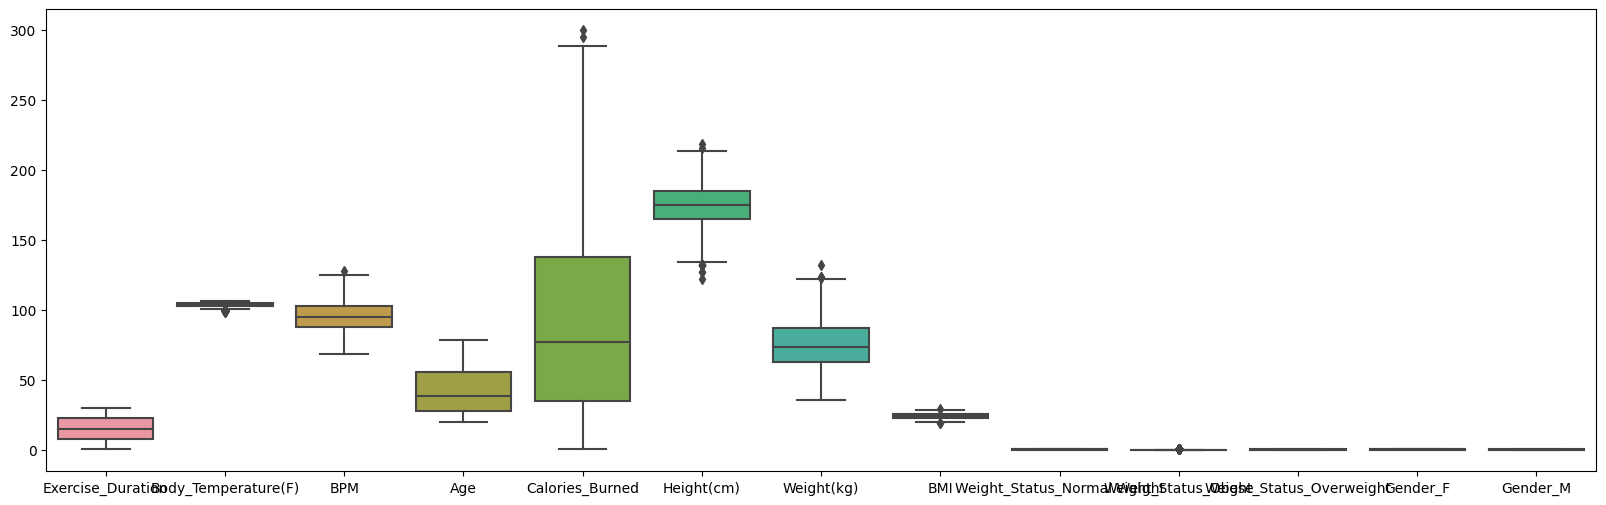

In [ ]:
plt.figure(figsize = (20,6))
sns.boxplot(data = train)

In [ ]:
train.head()

,Exercise_Duration,Body_Temperature(F),BPM,Age,Calories_Burned,Height(cm),Weight(kg),BMI,Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight,Gender_F,Gender_M
ID,,,,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,45,166.0,175.26,69.989303,22.785893,1,0,0,1,0
TRAIN_0001,7.0,103.3,88.0,50,33.0,198.12,102.012924,25.989538,0,0,1,0,1
TRAIN_0002,7.0,103.3,86.0,29,23.0,190.50,99.019214,27.285349,0,0,1,0,1
TRAIN_0003,17.0,104.0,99.0,33,91.0,167.64,66.995593,23.839159,1,0,0,1,0
TRAIN_0004,9.0,102.7,88.0,38,32.0,177.80,77.019984,24.363513,1,0,0,0,1


Index([], dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TRAIN_0000 to TRAIN_7499
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Exercise_Duration            7500 non-null   float64
 1   Body_Temperature(F)          7500 non-null   float64
 2   BPM                          7500 non-null   float64
 3   Age                          7500 non-null   int64  
 4   Calories_Burned              7500 non-null   float64
 5   Height(cm)                   7500 non-null   float64
 6   Weight(kg)                   7500 non-null   float64
 7   BMI                          7500 non-null   float64
 8   Weight_Status_Normal Weight  7500 non-null   uint8  
 9   Weight_Status_Obese          7500 non-null   uint8  
 10  Weight_Status_Overweight     7500 non-null   uint8  
 11  Gender_F                     7500 non-null   uint8  
 12  Gender_M                     7500 non-null   uint8  
dtypes: float

(None, None)

# X, y 만들기

In [ ]:
X = train.drop(columns="Calories_Burned")
y = train["Calories_Burned"]

X.shape, y.shape

((7500, 12), (7500,))

In [ ]:
# train_test_split을 이용해 X, y 값을 X_train, X_valid, y_train, y_valid 으로 나눠줍니다.
# Hold-out-valiation을 위해 train, valid 세트로 나누기
# test_size=0.1 => 이름은 test지만 train으로 나눠주었기 때문에 valid 사이즈를 지정한 것입니다.
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, random_state=42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6750, 12), (750, 12), (6750,), (750,))

In [ ]:
X_test = test
X_test.shape

(7500, 12)

In [ ]:
# tensorflow import 
import tensorflow  as tf

In [ ]:
X_train.iloc[0].shape

(12,)

In [60]:
#신경망 생성

epo = 30
model = tf.keras.Sequential([
    # tf.keras.layers.BatchNormalization(input_shape=X_train.iloc[0].shape),
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=X_train.iloc[0].shape),
    tf.keras.layers.Dense(units=132, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [61]:
# 모형 컴파일
model.compile(loss='mean_squared_error', 
              optimizer='adam', 
              metrics=['mean_squared_error'])

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               3328      
                                                                 
 dense_11 (Dense)            (None, 132)               33924     
                                                                 
 dense_12 (Dense)            (None, 128)               17024     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 62,597
Trainable params: 62,597
Non-trai

In [63]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train, y_train, 
                    epochs=100, validation_data=(X_valid, y_valid),
                    callbacks=[early_stop],batch_size=5)
history

Epoch 1/100
1350/1350 [==============================] - 8s 4ms/step - loss: 569.7732 - mean_squared_error: 569.7732 - val_loss: 193.6008 - val_mean_squared_error: 193.6008
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 152.3025 - mean_squared_error: 152.3025 - val_loss: 135.1803 - val_mean_squared_error: 135.1803
Epoch 3/100
1350/1350 [==============================] - 6s 4ms/step - loss: 149.2070 - mean_squared_error: 149.2070 - val_loss: 36.5489 - val_mean_squared_error: 36.5489
Epoch 4/100
1350/1350 [==============================] - 8s 6ms/step - loss: 131.4413 - mean_squared_error: 131.4413 - val_loss: 22.2778 - val_mean_squared_error: 22.2778
Epoch 5/100
1350/1350 [==============================] - 6s 5ms/step - loss: 138.8795 - mean_squared_error: 138.8795 - val_loss: 32.1231 - val_mean_squared_error: 32.1231
Epoch 6/100
1350/1350 [==============================] - 7s 5ms/step - loss: 126.3978 - mean_squared_error: 126.3978 - val_loss: 20.6175 - va

In [55]:
# 트레이닝 데이터 평가
print(model.evaluate(X_valid, y_valid)[1])

24/24 [==============================] - 0s 2ms/step - loss: 6.2831 - mean_squared_error: 6.2831
6.283114433288574


In [58]:
mse = history.history['mean_squared_error'] 
print(mse)

[596.2760620117188, 154.0333709716797, 142.40838623046875, 141.05784606933594, 135.56591796875, 119.86624908447266, 131.9001007080078, 116.12102508544922, 118.18297576904297, 111.38224029541016, 110.67039489746094, 110.61607360839844, 106.80516052246094, 107.5972671508789, 103.70979309082031, 108.83108520507812, 110.9529037475586, 106.77031707763672, 107.50328826904297, 100.19044494628906, 105.22174072265625, 95.2842025756836, 97.7431411743164, 94.16226959228516, 90.3538818359375, 94.92071533203125, 91.6607894897461, 94.68253326416016, 92.04187774658203, 88.06727600097656, 91.1314926147461, 82.11420440673828, 87.30779266357422, 85.32319641113281, 88.00797271728516, 85.29624938964844, 78.88319396972656, 79.36746215820312, 81.27953338623047, 83.17426300048828, 79.62261962890625, 75.70852661132812, 79.80171966552734, 84.19940185546875, 79.30046081542969, 80.28185272216797, 82.27542877197266, 79.50452423095703, 76.13279724121094, 77.09146881103516, 72.95042419433594, 79.65796661376953, 75.

In [59]:
loss = history.history['loss'] 
print(loss)

[596.2760620117188, 154.0333709716797, 142.40838623046875, 141.05784606933594, 135.56591796875, 119.86624908447266, 131.9001007080078, 116.12102508544922, 118.1829605102539, 111.38224029541016, 110.67039489746094, 110.61607360839844, 106.80516052246094, 107.59725952148438, 103.70979309082031, 108.83108520507812, 110.9529037475586, 106.77031707763672, 107.50328826904297, 100.19044494628906, 105.22174835205078, 95.2842025756836, 97.7431411743164, 94.16226959228516, 90.3538818359375, 94.92071533203125, 91.6607894897461, 94.68253326416016, 92.04187774658203, 88.06727600097656, 91.1314926147461, 82.11420440673828, 87.30779266357422, 85.32319641113281, 88.00797271728516, 85.29624938964844, 78.88319396972656, 79.36746215820312, 81.27953338623047, 83.17426300048828, 79.62261962890625, 75.70852661132812, 79.8017349243164, 84.19940185546875, 79.30046081542969, 80.28185272216797, 82.27542877197266, 79.50452423095703, 76.13279724121094, 77.09146881103516, 72.95042419433594, 79.65796661376953, 75.5

In [64]:
# 손실 학습 그래프
import matplotlib.pyplot as plt
plt.plot(epochs, loss, 'r', label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# MSE 학습 그래프
import matplotlib.pyplot as plt
plt.plot(epochs, mse, label='mse')
plt.xlabel('epochs')
plt.ylabel('mean_squred_error')
plt.legend()
plt.show()

In [ ]:
loss = history.history['loss'] 
print(loss)

In [ ]:
# 실제값, 예측값 데이터 프레임 생성
pred_y = model.predict(X_test).flatten() 
print(pred_y)

In [ ]:
import pandas as pd
res_df = pd.DataFrame(pred_y, columns=['predict_val'])
res_df['real_val'] = y_te

In [ ]:
# df_hist
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,mse,mae,val_loss,val_mse,val_mae
102,258.762878,258.762878,11.733859,12.899782,12.899782,2.504675
103,219.906006,219.906006,10.983678,98.471199,98.471199,7.960688
104,235.977921,235.977921,11.155920,41.703381,41.703381,5.114644
105,206.948273,206.948273,10.472921,37.379745,37.379745,4.771301
106,201.572540,201.572540,10.372279,55.492741,55.492741,5.322543


<Axes: >

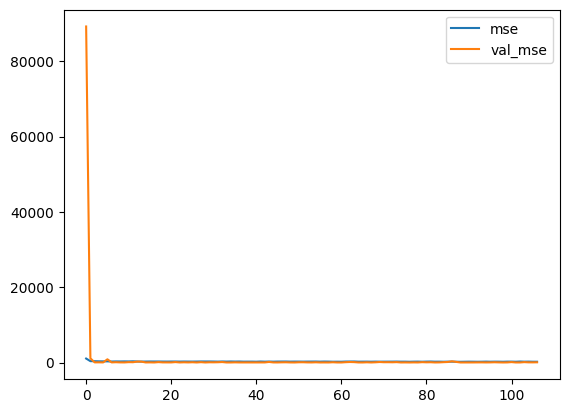

In [ ]:
# mse plot
df_hist[['mse','val_mse']].plot()

In [ ]:
# loss, mae, mse = model.evaluate
model.evaluate(X_valid, y_valid)

24/24 [==============================] - 0s 3ms/step - loss: 55.4927 - mse: 55.4927 - mae: 5.3225


[55.492740631103516, 55.492740631103516, 5.322542667388916]

In [ ]:
# predict
y_valid_pred = model.predict(X_valid).flatten()
y_valid_pred[:5]

24/24 [==============================] - 0s 2ms/step


array([ 17.348875, 126.46677 , 114.67315 ,  16.398977,  21.568396],
      dtype=float32)

In [ ]:
# predict
y_predict = model.predict(X_test).flatten()
y_predict[:5]

235/235 [==============================] - 0s 2ms/step


array([165.2305  , 175.45537 ,  52.128338, 154.35608 , 204.77536 ],
      dtype=float32)

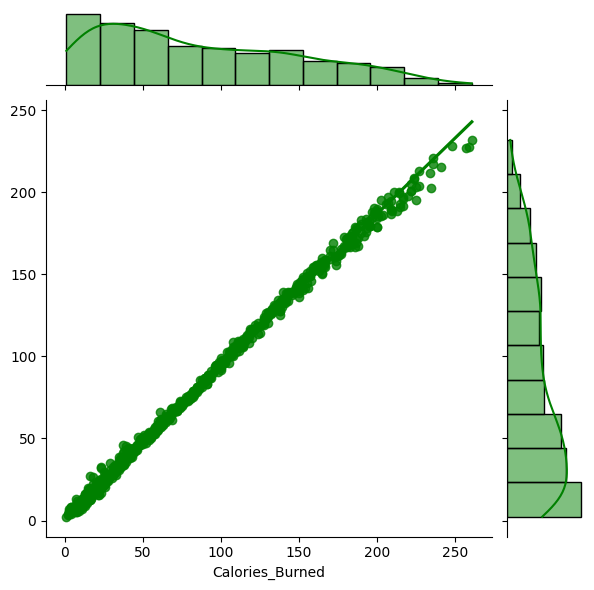

In [ ]:
# jointplot
sns.jointplot(x=y_valid, y=y_valid_pred, kind="reg", color='green')

In [ ]:
from sklearn.metrics import r2_score

r2=r2_score(y_valid, y_valid_pred)
r2

0.9860890522099051

In [ ]:
sample_submission["Calories_Burned"] = y_predict 
sample_submission

,Calories_Burned
ID,
TEST_0000,165.230499
TEST_0001,175.455368
TEST_0002,52.128338
TEST_0003,154.356079
TEST_0004,204.775360
...,...
TEST_7495,181.736267
TEST_7496,10.845786
TEST_7497,125.655891


In [ ]:
file_name = f"submit_tf_{r2:.5f}.csv"
file_name

'submit_tf_0.98609.csv'

In [ ]:
sample_submission.to_csv(file_name)
pd.read_csv(file_name).head()

,ID,Calories_Burned
0,TEST_0000,165.230500
1,TEST_0001,175.455370
2,TEST_0002,52.128338
3,TEST_0003,154.356080
4,TEST_0004,204.775360
